In [8]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
from shapely.geometry import Point
from fiona.crs import from_epsg
import math
from rtree import index
from scipy import spatial
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib.font_manager import FontProperties

font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')

sns.set(style="white")
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":14,"axes.labelsize":14})  
savefolder = './_graphic'
colorvaris = {
#     'base':'#000000',
              'R':'#f37354',
#     'R':'#ffbbb1',
#              'P':'#ff8f80',
#     'P':'#ea1121',
    'P':"#3BC0CF",
#     'S':'#3BC0CF',
    'S':'#0e6da1',
    'geo':'#F4B44B',
    'grey':'#d1d3d4'
             }
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_height = patch.get_height()
        diff = current_height - new_value

        # we change the bar width
        patch.set_height(new_value)

        # we recenter the bar
        patch.set_y(patch.get_y() + diff * .3)
        
def change_width_x(ax, new_value) :
    for patch in ax.patches :
        current_height = patch.get_height()
        diff = current_height - new_value

        # we change the bar width
        patch.set_height(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .3)

In [2]:

cols = ['g', 'd', 'c', 'gd', 'gc', 'dc', 'gdc']
def cleanlmg(df):
    df.columns = ['variables', 
                  "g", # geographical context
                  "g_t",
                  "d", # three d paramters
                  "d_t",
                  "c", # count of visitors
                  "c_t",
                  "gd",
                  "gd_t",
                  "gc",
                  "gc_t",
                  "dc",
                  "dc_t",
                  "gdc",
                  "gdc_t"
                 ]
    coeffcols = [col for col in df.columns if not "_t" in col]
    tcols = [col for col in df.columns if "_t" in col]+['variables']
    R2DF = df[df['variables']=="R-sq"][coeffcols]
    R2DF.head()
    return R2DF

def getLMG(R, P, S, RP, RS, SP, RPS):
#     """
#     R: Residential Variable Alone
#     P: Place variables (POI) Alone
#     S: Street View Variables Alone
#     """
    PR = RP
    SR = RS
    PS = SP
    
    # R given P equals to combined RP - P
    R_P = RP - P
    R_S = RS - S
    R_SP = RPS - SP
    
    P_S = PS - S
    P_R = PR - R
    P_SR = RPS - SR

    S_R = SR - R
    S_P = SP - P
    S_PR = RPS - PR


    lmgR = 1/6*(2* R + R_P + R_S + 2*R_SP)
    lmgS = 1/6*(2* S + S_P + S_R + 2*S_PR)
    lmgP = 1/6*(2* P + P_R + P_S + 2*P_SR)
    
    return lmgR, lmgP, lmgS

def getlmgdf(R2DF, col):
    for v in col:
        R2DF[v] = R2DF[v].astype(float)
    R2DF['lmg'] = R2DF.apply(lambda row: getLMG(row[col[0]], row[col[1]], row[col[2]],
                                            row[col[0]+col[1]], row[col[0]+col[2]], row[col[1]+col[2]],
                                           row[col[0] + col[1]+col[2]]), axis = 1
                        )
    R2DF[f'lmg{col[0]}'] = R2DF['lmg'].apply(lambda x:x[0])
    R2DF[f'lmg{col[1]}'] = R2DF['lmg'].apply(lambda x:x[1])
    R2DF[f'lmg{col[2]}'] = R2DF['lmg'].apply(lambda x:x[2])

    test = R2DF.copy()
    test[f'lmg{col[0]}_p'] = test[f'lmg{col[0]}']/test[col[0] + col[1]+col[2]]
    test[f'lmg{col[1]}_p'] = test[f'lmg{col[1]}']/test[col[0] + col[1]+col[2]]
    test[f'lmg{col[2]}_p'] = test[f'lmg{col[2]}']/test[col[0] + col[1]+col[2]]

    test[f'lmg{col[0]+col[1]}'] = test[f'lmg{col[0]}_p']+test[f'lmg{col[1]}_p']
    test[f'lmg{col[0]+col[2]}'] = test[f'lmg{col[0]}_p']+test[f'lmg{col[2]}_p']
    test[f'lmg{col[1]+col[2]}'] = test[f'lmg{col[1]}_p']+test[f'lmg{col[2]}_p']
    # test['lmg']
    test[f'lmg{col[0] + col[1]+col[2]}'] = test[f'lmg{col[0]}_p']+test[f'lmg{col[1]}_p'] + test[f'lmg{col[2]}_p']


    test = test.sort_values([f'lmg{col[0]}_p'], ascending = False)
    return test

In [9]:
folder = "./_table/lmg"
variablenames = {
    'lmgc_p':"LMG Log(Count of Visitors)",
    'lmgg_p':"Geographical Context",
    'lmgd_p':"Income + Residential Diversity + POI + Safety",
    "c":"Log(Count of Visitors)",
    "p":"Income + Residential Diversity + POI + Safety",
    "g":"Geographical Context",
    "densityCorrelation": "Density Correlation"

}
files = os.listdir(folder)
DF = []
for f in files:
    df = pd.read_csv(os.path.join(folder, f))[1:]
    time = f.split("_")[-1][:-4]
    R2DF = cleanlmg(df)
    lmg = getlmgdf(R2DF, cols)
    lmg["unique_user_min"] = int(time)*5
    DF.append(lmg)
DF = pd.concat(DF).reset_index(drop = True)
DF["densityCorrelation"] = DF["c"].apply(lambda x: x**0.5)
DF.head()

,variables,g,d,c,gd,gc,dc,gdc,lmg,lmgg,...,lmgc,lmgg_p,lmgd_p,lmgc_p,lmggd,lmggc,lmgdc,lmggdc,unique_user_min,densityCorrelation
0,R-sq,0.046470,0.117921,0.189281,0.137395,0.233465,0.251437,0.278452,"(0.035104699999999996, 0.0798158, 0.163531)",0.035105,...,0.163531,0.126071,0.286642,0.587287,0.412713,0.713358,0.873929,1.0,5,0.435064
1,R-sq,0.073832,0.137344,0.060632,0.177332,0.141008,0.177717,0.224914,"(0.06040324999999999, 0.110514, 0.05399635)",0.060403,...,0.053996,0.268562,0.491362,0.240076,0.759924,0.508638,0.731438,1.0,50,0.246237
2,R-sq,0.073837,0.134077,0.056784,0.176216,0.137882,0.172788,0.222455,"(0.06170763333333333, 0.10928013333333333, 0.0...",0.061708,...,0.051467,0.277394,0.491246,0.231360,0.768640,0.508754,0.722606,1.0,55,0.238294
3,R-sq,0.076189,0.136382,0.054906,0.179198,0.137748,0.174077,0.224005,"(0.06298196666666665, 0.11124276666666667, 0.0...",0.062982,...,0.049780,0.281164,0.496609,0.222227,0.777773,0.503391,0.718836,1.0,60,0.234321
4,R-sq,0.077278,0.133716,0.050780,0.178741,0.134910,0.168277,0.220464,"(0.06468058333333332, 0.10958368333333335, 0.0...",0.064681,...,0.046200,0.293384,0.497059,0.209558,0.790442,0.502941,0.706616,1.0,65,0.225345


In [50]:
# Scatter Plot
def plotscatter(data, y, title):
    fig, ax = plt.subplots(figsize = (5, 5))
    sns.pointplot(x = 'unique_user_min', y = y, 
                  data = data, 
                  # color = colortopicset[topic],
                  errwidth = 1,
                  scale = 0.7,
                  labels = variablenames[y],
                  dodge = True

                   )


    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.set_xlabel("Minimum Number of Unique User", size = 12)
    ax.set_ylabel(variablenames[y], size = 12)
    #plt.grid(visible = True, which = 'major')
    plt.yticks(size = 10)
    plt.xticks(size = 10)
    plt.legend(fontsize='large', title_fontsize='12', loc='lower left', bbox_to_anchor=(1, 0))
    fig.savefig(os.path.join(savefolder, f'{title}.svg'), dpi = 150)
    plt.show()
    
        
def barplot(data, y):
    fig, ax = plt.subplots(figsize = (8, 5))
    sns.pointplot(x = 'unique_user_min', y = y, 
                  data = data, 
                  # color = colortopicset[topic],
                  errwidth = 1,
                  scale = 0.7,
                  #labels = topic,
                  dodge = True

                   )


    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.set_xlabel("Minimum Number of Unique User", size = 12)
    ax.set_ylabel(variablenames[y], size = 12)
    #plt.grid(visible = True, which = 'major')
    plt.yticks(size = 10)
    plt.xticks(size = 10)
    # plt.legend(fontsize='large', title_fontsize='12', loc='lower left', bbox_to_anchor=(1, 0))
    # fig.savefig(os.path.join(graphicfolder, f'{title}.svg'), dpi = 150)
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


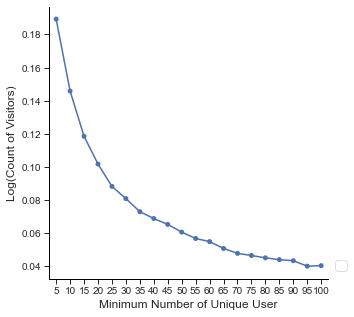

In [51]:
# Fig 3c
plotscatter(DF, "c","Fig3-c")

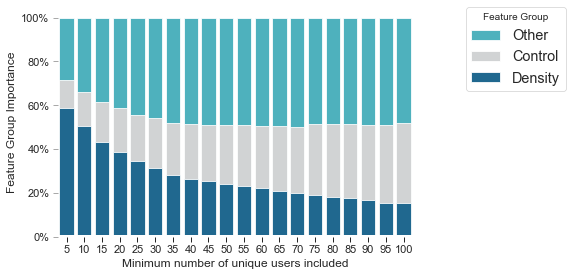

In [44]:
fig, ax = plt.subplots(figsize=(6,4))
# annotation shuffle value

g = sns.barplot(y='lmggdc',  x="unique_user_min", data=DF, color = colorvaris['P'], ax = ax,
           label = 'Other')

g = sns.barplot(y='lmggc',  x="unique_user_min", data=DF, 
                color = colorvaris['grey'], ax = ax,
           label ='Control')

s = sns.barplot(y="lmgc_p",  x="unique_user_min", data=DF, 
                color = colorvaris['S'], ax = ax,
           label ='Density')


# change_width_x(ax, .50)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
#     ax.spines['top'].set_color('grey')
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks_position('left')

# ax.grid(which='major', axis='x', linestyle = '-', linewidth = 0.5)

ax.axhline(y = 0, 
                   color = 'white', 
                   linestyle = '-',
                   linewidth = 4)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
# ax.set_xlim(0,1)

ax.tick_params(axis='x', labelsize= 11
              )
ax.tick_params(axis='y', labelsize= 11, color = 'darkgrey'
                  )
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax.set_xlabel("Minimum number of unique users included", size = 12)

ax.set_ylabel("Feature Group Importance", size = 12)
plt.tight_layout()
plt.legend(title="Feature Group",
           bbox_to_anchor=(1.15, 1), 
           loc='upper left', 
           borderaxespad=0, fontsize = 'large', title_fontsize = 10)
fig.savefig(os.path.join(savefolder, 'Fig3-b.svg'), dpi = 150)


# Fig 3 - Time-variant
## Fig 3a

In [13]:
# plot time-series change of ESM
esmtime = pd.read_csv("./_data/str_para_3city.csv")
esmtime.head()

,newid,park_dist_m,station_dist_m,name,county,length,tot_pop_cbgadj,over65_rateadj,black_peradj,white_peradj,...,unique_18_22,dist_home_18_22,year,safety,img_count,dist_center,city,residential,metro_county,yeargroup
0,100316263_3205,188.21332,181.78076,Union Park Street,25,298.49005,33496,0.104975,0.106111,0.612169,...,4.0,2694.2646,2016,5.347640,20,2.436398,boston,NaN,boston25,2016
1,100317419_19230,304.61646,282.11987,Traveler Street,25,509.52985,29845,0.116701,0.068062,0.586743,...,26.0,5344.5986,2016,4.702221,84,1.911024,boston,NaN,boston25,2016
2,100393446_6599,499.07950,97.75618,Adams Street,25,513.67273,14426,0.147649,0.242060,0.619787,...,1.0,6399.9639,2016,5.017894,36,9.052881,boston,NaN,boston25,2016
3,100393446_8691,597.80670,146.02646,Adams Street,25,224.76611,14739,0.145189,0.217855,0.645568,...,0.0,0.0000,2016,5.111622,4,8.945856,boston,NaN,boston25,2016
4,100393446_8697,658.78156,199.23624,Adams Street,25,308.02313,18137,0.136729,0.287260,0.576117,...,7.0,3495.5022,2016,5.318836,44,8.865147,boston,NaN,boston25,2016


In [16]:
condition = ['unique_10_14',
        'unique_14_18',"unique_6_10","unique_18_22"]
for c in condition:
    esmtime=esmtime[esmtime[c]>19]
timecols = ['newid',"metro_county","city", 'div_6_10', 'div_10_14', 'div_14_18', 'div_18_22']

selviz2 = esmtime[timecols].dropna()
selviz2.columns = ['newid',"metro_county","city", 'div_0610', 'div_1014', 'div_1418', 'div_1822']
vizdf2 = pd.wide_to_long(selviz2, ["div"], i = ["newid","city"], j = "time", sep = "_").reset_index().sort_values(["city","time"]).reset_index(drop = True)
vizdf2.head()

,newid,city,time,metro_county,div
0,100317419_19230,boston,610,boston25,0.616162
1,101912038_426462221_8650317_426462233_42646223...,boston,610,boston25,0.667994
2,102521303_788,boston,610,boston21,0.716260
3,103680392_1637,boston,610,boston25,0.871949
4,107758311_29009,boston,610,boston17,0.680286


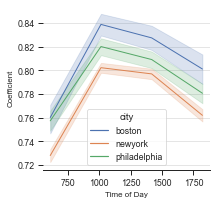

In [41]:
figexport,ax = plt.subplots(figsize=(3,3))


sns.lineplot(data= vizdf2, x =  'time', y = "div",
             hue = "city", 

             lw=1,
             ci = 98

            )

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.grid(which='major', axis='y', linestyle = '-', linewidth = 0.5)

ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)


ax.set_xlabel("Time of Day", size = 8)
ax.set_ylabel("Coefficient", size = 8)
figexport.savefig(os.path.join(savefolder, 'Fig4a-timeseriesESMMean.svg'),
                           dpi=150,
                      bbox_inches='tight')


## Fig 3b 

In [35]:

stresulthour = pd.read_csv("./_table/fig4_st_std_3city_byhourweek_unique20.csv")[1:]
stresulthour.head()

,Unnamed: 0,r11,Unnamed: 2,r12,Unnamed: 4,r13,Unnamed: 6,r14,Unnamed: 8,r21,Unnamed: 10,r22,Unnamed: 12,r23,Unnamed: 14,r24,Unnamed: 16
1,std_length,.0246796,3.53678,.0262688,3.915404,.0221629,3.226242,.0053706,.7742358,-.0143464,-2.002094,-.0098222,-1.408338,-.015261,-2.147211,-.0248019,-3.584357
2,std_logpopdensity,.0096652,.5461677,-.0076005,-.4237913,-.0179272,-1.004308,-.0548403,-3.086469,-.0144218,-.8446997,.0000547,.0031522,-.0116145,-.6763777,-.0463993,-2.737205
3,std_logincome,.0769555,5.720503,.0910339,6.357752,.1134533,7.931883,.0941244,6.840401,.0867041,6.670984,.1012937,7.33474,.1309642,9.50403,.1197682,8.896733
4,std_incomediversity4adj,.1192084,12.50429,.1664458,17.03546,.1821134,18.87919,.1869647,19.69012,.1204229,13.06726,.1640753,17.33353,.1779814,19.03605,.1778091,19.17256
5,std_logfood,.0356985,3.507638,.0421421,4.132071,.0434352,4.288132,.0536082,5.488595,.021988,2.237942,.0160274,1.627658,.0213055,2.182156,.020644,2.177921


In [36]:
# Clean column names
strcols = [
           'rt610','rt610_t',
           'rt1014','rt1014_t',
           'rt1418','rt1418_t',
           'rt1822','rt1822_t',
           'rtw610','rtw610_t',
           'rtw1014','rtw1014_t',
           'rtw1418','rtw1418_t',
           'rtw1822','rtw1822_t',
                       ]
tcolshour2 = ['variables',
                'rt610_t',
                'rt1014_t',
                'rt1418_t',
                'rt1822_t',
                'rtw610_t',
                'rtw1014_t',
                'rtw1418_t',
                'rtw1822_t',
               ]

coefcolshour2 = ['variables',
                'rt610',
                'rt1014',
                'rt1418',
                'rt1822',
                'rtw610',
                'rtw1014',
                'rtw1418',
                'rtw1822',
               ]

strvaris = ['std_logdist', 'std_length', 'std_logpopdensity', 'std_logincome',
       'std_bachelor_rateadj', 'std_incomediversity4adj', 'std_logfood',
       'std_logshopping', 'std_logcollege', 'std_logwork',
       'std_logsports', 'std_logtransportation', 'std_logservice',
       'std_logschool',  'std_loghealth',
       'std_loggrocery', 'std_logentertainment', 'std_logcoffeetea',
       'std_logartsmuseum', 'std_logcityoutdoors', 'std_safety','std_safety2']
strvarisnames2 = ['Dist. CBD',
                  'Seg Length',
    'Pop. Dens.', 'Income',
       '% Bachelor', 'Resi. Diversity',
       # 'Dist. Park', 'Dist. Station(m)',
       '#Food', '#Shopping', '#College',
       '#Work', '#Sports', '#Transportation',
       '#Service', '#School', 
    '#Health', '#Grocery', '#Entertainment',
                 '#Coffee / Tea', '#Arts / Museum', '#City / Outdoor',
       'Street Score','Street Score(sq)'
]

# Selected Variables to show
selvaris = [
    'Pop. Dens.', 'Income',
        'Resi. Diversity',
       # 'Dist. Park', 'Dist. Station(m)',
       '#Food', '#Shopping', '#College',
       '#Work', '#Sports', '#Transportation',
       '#Service', 
#     '#School', 
#     '#Religious',
    '#Health', '#Grocery', '#Entertainment',
     '#Coffee / Tea', '#Arts / Museum', '#City / Outdoor',
       'Street Score'
    
]
# Set up colors
colorset = [
#     "#cccc33",
#             "#34B07A",
#             "#cc6666",
    "#0099cc",
            # "#005F79",
            '#efa020', 
      
    "#DB4F51",
    "#003366",
            "#996633",
            "#005F79",
            "#C9659C",
            
            "#92A84D",
            "#cccccc" #grey
           ]
colorcols = [
#     'Pop. Dens.', 'Income', 'Resi. Diversity',
             # '% Bachelor',
             "#Grocery",
       '#Food',
#     '#Service', 
    '#Shopping', 
    '#Health',
             '#Entertainment',  
             '#Coffee / Tea', 
             "#Work",
            "#College"
             # '#Arts / Museum'
            ]
# '% Bachelor', 


# colordict = dict(zip(colorcols, colorset))
colordict = {
    '#Food': '#efa020', 
    '#Coffee / Tea':"#0099cc",
    "#College":"#92A84D",
    "#Work":"#C9659C",
    '#Entertainment': "#996633",
    '#Health':"#003366",
    '#Shopping':"#DB4F51",
    "#Grocery": "#005F79",
}
greycols = [co for co in selvaris if not co in colordict.keys()]
strvaridict2 = dict(zip(strvaris, strvarisnames2))

In [37]:

stresulthour.columns = ['variables']+strcols
df2hourst = stresulthour[stresulthour['variables'].isin(strvaris)]
for c in strcols:
    df2hourst[c] = df2hourst[c].astype(float)
df2hourst['variables'] = df2hourst['variables'].apply(lambda x: strvaridict2[x])
df2hourst = df2hourst[df2hourst['variables'].isin(selvaris)]

tdfhourst = df2hourst[tcolshour2].set_index('variables')
tdfhourst = tdfhourst.reindex(index = selvaris).T

coeffdfhourst = df2hourst[coefcolshour2].set_index('variables')
coeffdfhourst = coeffdfhourst.reindex(index = selvaris).T

colormatrix = coeffdfhourst.copy()
for i, c in enumerate(colorcols):
    colormatrix.loc[:,c] = colorset[i]
for i, c in enumerate(greycols):
    colormatrix.loc[:,c] = "#cccccc"
    
threshold = 1.98
colormt = colormatrix.values
colormt[(tdfhourst.values>threshold)&(tdfhourst.values<threshold*-1)] = '#ffffff'
colormatrix = pd.DataFrame(colormt, columns = colormatrix.columns,
                          index = colormatrix.index)

colormt2 = coeffdfhourst.copy()
colormt2[(tdfhourst.values<threshold*-1)|(tdfhourst.values>threshold)] = np.nan
coeffdfhourst2 = pd.DataFrame(colormt2, columns = colormatrix.columns,
                          index = colormatrix.index)

C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_20256\706217851.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2hourst[c] = df2hourst[c].astype(float)
C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_20256\706217851.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2hourst['variables'] = df2hourst['variables'].apply(lambda x: strvaridict2[x])


In [45]:
def plotscatter(coeffdfhourst, weekdays, varils, title, figsize=(8,6)):
    
    scatterviz = coeffdfhourst[varils].reset_index().rename(columns = {'index':'time'})
    scatterviz = scatterviz[scatterviz['time'].isin(weekdays)]
    
    scatterviz2 = coeffdfhourst2[varils].reset_index().rename(columns = {'index':'time'})
    scatterviz2 = scatterviz2[scatterviz2['time'].isin(weekdays)]
    greycols2 = [x for x in greycols if x in varils]
    colorcols2 = [x for x in colorcols if x in varils]
    
    
    figexport,ax = plt.subplots(figsize=figsize)
    for x in greycols2:
        sns.scatterplot(data= scatterviz, x =  'time', y = x,
                       s = 40, 
                        color = colorset[-1],

                       )
        sns.lineplot(data= scatterviz, x =  'time', y = x,
                     markers=True, dashes=False, color = colorset[-1],
                     label = "Other")
        
    for i, x in enumerate(colorcols2):
        sns.lineplot(data= scatterviz, 
                     x =  'time', 
                     y = x,
                     markers=True, 
                     dashes=False, 
                     color = colordict[x],
                     label = x)
        sns.scatterplot(
                data = scatterviz,
                x = 'time', 
                y = x,
                s = 60, 
#                 facecolor = "white",
                color = colordict[x],
                           )
        sns.scatterplot(
            data = scatterviz2,
            x = 'time', 
                y = x,
                s = 60, 
                facecolor = "white",
                edgecolor = colordict[x],
        )
        

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.grid(which='major', axis='y', linestyle = '-', linewidth = 0.5)

    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.set_xlabel("Time of Day", size = 6)
    ax.set_ylabel("Coefficient", size = 6)

    plt.legend(title="Feature Group",
               bbox_to_anchor=(1.15, 1), 
               loc='upper left', 
               borderaxespad=0, fontsize = 'large', title_fontsize = 7)
    figexport.savefig(os.path.join(savefolder, f'Fig3-{title}.svg'),
                           dpi=150,
                      bbox_inches='tight')


C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_20256\3418819315.py:65: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  figexport.savefig(os.path.join(savefolder, f'Fig3-{title}.svg'),
C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_20256\3418819315.py:65: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  figexport.savefig(os.path.join(savefolder, f'Fig3-{title}.svg'),
C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_20256\3418819315.py:65: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  figexport.savefig(os.path.join(savefolder, f'Fig3-{title}.svg'),
C:\Users\y

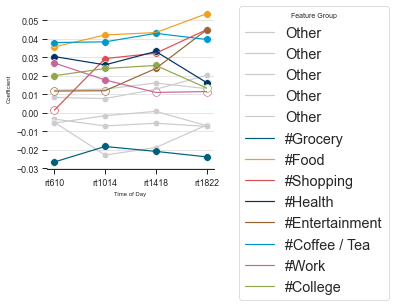

In [46]:
weekdaycols = ['rt610', 'rt1014', 'rt1418', 'rt1822']
weekdaycols_count = ['rtw610', 'rtw1014','rtw1418', 'rtw1822']

varils = ['#Food',
       '#Shopping', '#College', '#Work', '#Sports', '#Transportation',
       '#Service', 
          '#Health', '#Grocery',
       '#Entertainment', '#Coffee / Tea', '#Arts / Museum', '#City / Outdoor']

plotscatter(
    coeffdfhourst, 
    weekdaycols,
    varils,
    'weekdaycoeff_poi_esm',
    figsize=(3,3),
           )

C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_20256\3418819315.py:65: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  figexport.savefig(os.path.join(savefolder, f'Fig3-{title}.svg'),
C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_20256\3418819315.py:65: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  figexport.savefig(os.path.join(savefolder, f'Fig3-{title}.svg'),
C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_20256\3418819315.py:65: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  figexport.savefig(os.path.join(savefolder, f'Fig3-{title}.svg'),
C:\Users\y

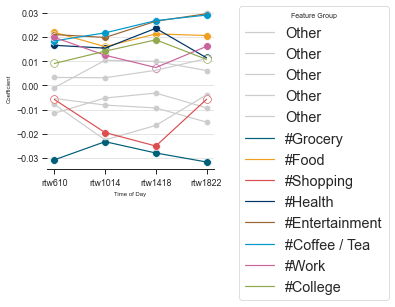

In [47]:
plotscatter(
    coeffdfhourst, 
    weekdaycols_count,
    varils,
    'weekdaycoeff_poi_esm_count',
    figsize=(3,3),
           )